#### Submission Note: Nov 5th 2024 Danni Hou

1. The following codes are my attempt to tackle task 4
2. I used Qiskit and it's prebuilt functions to:
*   constructed quantum circuit from the given state vector, using Initialize()
*   constructed coupling map manually
*   customized Target to include only basis gates and considering hardware limitations, by using and configuring PassManager function
3. I was able to compile quantum circuit to be compliant to hardware and with basis gates only, but unable to reach ideal gate depth of below 50. Any tips on how to achieve that would be appreciated!

#### Step 0: import libraries and modules

In [1]:
import numpy as np
from math import pi
from qiskit.circuit.library import QFT
from qiskit.circuit.library import Initialize
from qiskit.providers.fake_provider import GenericBackendV2, generic_backend_v2

from qiskit import transpile, QuantumCircuit
from qiskit.circuit import Gate
from qiskit.converters import circuit_to_dag
from qiskit.transpiler import CouplingMap, StagedPassManager, PassManager, AnalysisPass, TransformationPass
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.preset_passmanagers.common import generate_unroll_3q, generate_embed_passmanager
from qiskit.transpiler.passes import RemoveFinalReset, RemoveResetInZeroState
from qiskit.quantum_info import hellinger_fidelity, Statevector
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.dagcircuit import DAGCircuit
from qiskit_ibm_runtime.fake_provider import FakeTorino

# Transpiler Passes
## Layout passes
from qiskit.transpiler.passes.layout.csp_layout import CSPLayout
from qiskit.transpiler.passes.layout.dense_layout import DenseLayout
from qiskit.transpiler.passes.layout.sabre_layout import SabreLayout
from qiskit.transpiler.passes.layout.vf2_layout import VF2Layout
from qiskit.transpiler.passes.layout.trivial_layout import TrivialLayout

## Routing passes
from qiskit.transpiler.passes.routing.basic_swap import BasicSwap
from qiskit.transpiler.passes.routing.lookahead_swap import LookaheadSwap
from qiskit.transpiler.passes.routing.sabre_swap import SabreSwap
from qiskit.transpiler.passes.routing.stochastic_swap import StochasticSwap
from qiskit.transpiler.passes.routing.star_prerouting import StarPreRouting

## Synthesis passes (passes for the translation stage)
from qiskit.circuit import SessionEquivalenceLibrary
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary
from qiskit.transpiler.passes.basis.basis_translator import BasisTranslator
from qiskit.transpiler.passes.synthesis.high_level_synthesis import HighLevelSynthesis
### The next pass could also be considered an optimization pass.
from qiskit.transpiler.passes.synthesis.unitary_synthesis import UnitarySynthesis

## Optimization passes
from qiskit.transpiler.passes.optimization.collect_1q_runs import Collect1qRuns
from qiskit.transpiler.passes.optimization.collect_2q_blocks import Collect2qBlocks
from qiskit.transpiler.passes.optimization.consolidate_blocks import ConsolidateBlocks
from qiskit.transpiler.passes.optimization.commutative_cancellation import CommutativeCancellation
from qiskit.transpiler.passes.optimization.optimize_1q_decomposition import Optimize1qGatesDecomposition

## Transformation passes

## Visualization
import matplotlib.pyplot as plt
import networkx as nx

#### Step 1: Translate State Vector into Quantum Circuit

In [10]:
#input state vector

size = 5
state_values = [22,17,27,12]
state_vector = [0]*2**size
for s in state_values:
   print(np.binary_repr(s,size))
   state_vector[s] = 0.5
np.asarray(state_vector)

10110
10001
11011
01100


array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5,
       0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. ,
       0. , 0.5, 0. , 0. , 0. , 0. ])

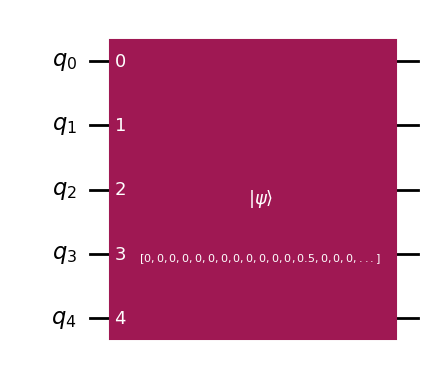

In [11]:
#construct quantum circuit

qc = QuantumCircuit(size)

state = Statevector(state_vector)

init_gate = Initialize(state)
qc.append(init_gate, [0, 1, 2, 3, 4])

qc.draw(output='mpl')

#### Step 2: Retrieve Information of the Quantum Circuit

In [4]:
def get_qc_characteristics(qc):
    depth = qc.depth()
    num_qubits = qc.num_qubits
    ops = qc.count_ops()
    num_multi_qubit_ops = sum(1 for data in qc.data if len(data[1]) > 1)
    return {"depth":depth, "num_qubits":num_qubits, "ops":ops, "num_multi_qubit_ops": num_multi_qubit_ops}    

def print_qc_characteristics(qc):
    characteristics = get_qc_characteristics(qc)
    print("Quantum circuit characteristics")
    print("  Depth:", characteristics['depth'])
    print("  Number of qubits:", characteristics['num_qubits'])
    print("  Operations:", dict(characteristics['ops']))
    print("  Number of multi-qubit Operations:", characteristics['num_multi_qubit_ops'])

print_qc_characteristics(qc)

Quantum circuit characteristics
  Depth: 1
  Number of qubits: 5
  Operations: {'initialize': 1}
  Number of multi-qubit Operations: 1


#### Step 3: Define Target

Coupling map: [[0, 1], [0, 4], [1, 4], [2, 3], [2, 4], [3, 4]]


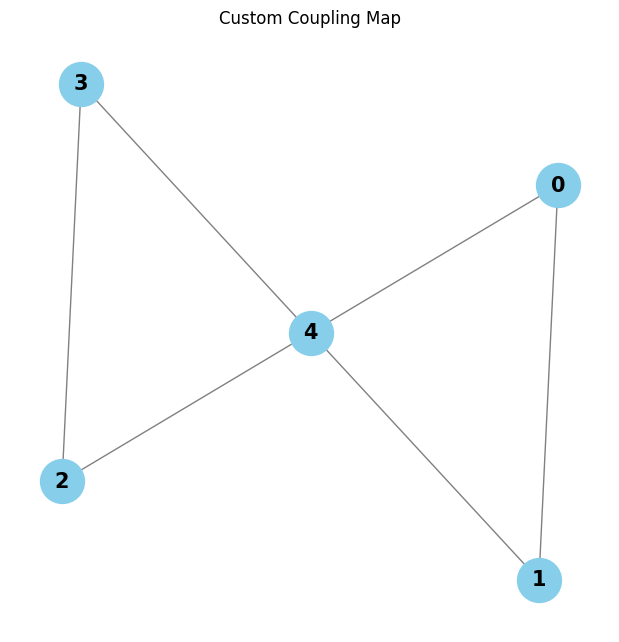

In [5]:
#define basis gates
basis_gates = ['x', 'h', 'rz', 'cx']

#define coupling map
connections = [(0, 1), (0, 4), (1, 4), (2, 3), (2, 4),(3,4)]
coupling_map = CouplingMap(connections)
print("Coupling map:", coupling_map)

#drawing out coupling map
graph = nx.Graph()
graph.add_edges_from(connections)

plt.figure(figsize=(6, 6))
nx.draw(graph, with_labels=True, node_color='skyblue', node_size=1000, font_size=15, font_weight='bold', edge_color='gray')
plt.title("Custom Coupling Map")
plt.show()


#### Step 4: Decomposing the quantum circuit

In [13]:
#Step 4a: using Qiskit default decomposition

backend = GenericBackendV2(size)
qc_synth = generate_preset_pass_manager(3, backend=backend).run(qc)
print_qc_characteristics(qc_synth)
qc_synth.draw(fold=-1)

Quantum circuit characteristics
  Depth: 78
  Number of qubits: 5
  Operations: {'rz': 38, 'sx': 38, 'cx': 22, 'reset': 5}
  Number of multi-qubit Operations: 22


global phase: π/2
              ┌────────┐┌────┐  ┌─────────┐  ┌────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
q_4 -> 0 ─|0>─┤ Rz(-π) ├┤ √X ├──┤ Rz(π/3) ├──┤ √X ├──■────────────────────────────────────────■───────────────────────────────────────────■─────────────────────────────────────────────────────────────────────────────■────────────────────────────────────────────────■──────────────────────────────────────────────────────────────────────────────────────────■───────────────────────────────────────────────────────────────────────────────────────■────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──
              ├────────┤├────┤┌─┴─────────┴─┐├────┤┌─┴─┐┌────────┐┌────┐┌────────────┐┌────┐┌─┴─┐                                         │                                                                             │                                                │                                                                                          │                                                                                       │                                                                                                                                                                │  
q_3 -> 1 ─|0>─┤ Rz(-π) ├┤ √X ├┤ Rz(0.95532) ├┤ √X ├┤ X ├┤ Rz(-π) ├┤ √X ├┤ Rz(2.1863) ├┤ √X ├┤ X ├──■──────────────────────────────────────┼──────────────────────────────────────■──────────────────────────────────────┼─────────■──────────────────────────────────────┼──────────────────────────────────────■───────────────────────────────────────────────────┼────■──────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────■─────────────────────────────────────────────────────────────────────────────┼──
              ├────────┤├────┤└─┬──────────┬┘├────┤└───┘└────────┘└────┘└────────────┘└────┘└───┘  │                                      │                                      │                                      │         │                                      │                                      │       ┌───┐  ┌────────┐ ┌────┐┌──────────┐┌────┐  │  ┌─┴─┐┌───┐┌────────┐┌────┐┌──────────┐┌────┐┌───┐┌────────┐┌────┐┌──────────┐┌────┐┌─┴─┐┌────┐┌──────────┐┌────┐┌────────┐┌───┐┌────┐┌──────────┐┌────┐┌────────┐┌───┐┌─┴─┐┌────┐┌──────────┐┌────┐┌────────┐┌───┐┌────┐┌──────────┐┌────┐┌────────┐┌─┴─┐
q_0 -> 2 ─|0>─┤ Rz(-π) ├┤ √X ├──┤ Rz(7π/8) ├─┤ √X ├────────────────────────────────────────────────┼──────────────────────────────────────┼──────────────────────────────────────┼──────────────────────────────────────┼─────────┼──────────────────────────────────────┼──────────────────────────────────────┼───────┤ X ├──┤ Rz(-π) ├─┤ √X ├┤ Rz(7π/8) ├┤ √X ├──┼──┤ X ├┤ X ├┤ Rz(-π) ├┤ √X ├┤ Rz(7π/8) ├┤ √X ├┤ X ├┤ Rz(-π) ├┤ √X ├┤ Rz(7π/8) ├┤ √X ├┤ X ├┤ √X ├┤ Rz(7π/8) ├┤ √X ├┤ Rz(-π) ├┤ X ├┤ √X ├┤ Rz(7π/8) ├┤ √X ├┤ Rz(-π) ├┤ X ├┤ X ├┤ √X ├┤ Rz(7π/8) ├┤ √X ├┤ Rz(-π) ├┤ X ├┤ √X ├┤ Rz(7π/8) ├┤ √X ├┤ Rz(-π) ├┤ X ├
              ├────────┤├────┤  ├──────────┤ ├────┤                                              ┌─┴─┐┌────┐┌──────────┐┌────┐┌────────┐┌─┴─┐┌────┐┌──────────┐┌────┐┌────────┐┌─┴─┐┌────────┐┌────┐┌──────────┐┌────┐┌─┴─┐       │                                      │                                      │       └─┬─┘  └────────

In [14]:
#Step 4b: compile to hardware compliant quantum circuits

#define staged pass manager
pm_staged = StagedPassManager()

pm_staged.init = generate_unroll_3q(None)

pm_staged.layout = PassManager()
pm_staged.layout += SabreLayout(coupling_map) #using SabreLayout for minimizing swap gates aka min. gate depth

routing_pass = SabreSwap(coupling_map, heuristic='basic') #using SabreSwap for minimizing swap gates aka min. gate depth
pm_staged.routing = PassManager(routing_pass)

translation_pass = BasisTranslator(equivalence_library=SessionEquivalenceLibrary,target_basis=basis_gates)
pm_staged.translation = PassManager(translation_pass)
# pm_staged.translation += HighLevelSynthesis()
# pm_staged.translation += UnitarySynthesis(basis_gates = basis_gates)

pm_staged.optimization = PassManager()
pm_staged.optimization += CommutativeCancellation(basis_gates = basis_gates)
pm_staged.optimization += Optimize1qGatesDecomposition(basis = basis_gates)
pm_staged.optimization += UnitarySynthesis()

pm_staged.layout += generate_embed_passmanager(coupling_map)

pm_staged.optimization += RemoveResetInZeroState()
pm_staged.optimization += RemoveFinalReset()

qc_routed_synth = pm_staged.run(qc_synth)
print_qc_characteristics(qc_routed_synth)
qc_routed_synth.draw(fold=-1)

Quantum circuit characteristics
  Depth: 98
  Number of qubits: 5
  Operations: {'rz': 57, 'h': 38, 'cx': 29}
  Number of multi-qubit Operations: 29


┌───────────┐┌───┐ ┌───────────┐ ┌───┐┌──────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
q_2 -> 0 ┤ Rz(-3π/2) ├┤ H ├─┤ Rz(-2π/3) ├─┤ H ├┤ Rz(-π/2) ├──■───────────────────────────────────────────────────────■────────────────────────────────────────────────────────■────────────────────────────────────────────────────────────────────────────────────────────────────────■───────────────────────────────────────────────────────────────────────────────────────────■───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──
         ├───────────┤├───┤ ├───────────┤ ├───┤├──────────┤  │                                                       │  ┌───┐┌──────────┐┌───┐┌──────────┐┌───┐┌───────────┐┌─┴─┐┌──────────┐┌───┐┌───────────┐┌───┐┌───────────┐┌───┐┌───────────┐┌───┐┌──────────┐┌───┐┌──────────┐┌─┴─┐     ┌───┐                                                                               │                                                                                                                                       │                                                                                                                      │                                                                                                                                                                                                                    │  
q_4 -> 1 ┤ Rz(-3π/2) ├┤ H ├─┤ Rz(-3π/8) ├─┤ H ├┤ Rz(-π/2) ├──┼───────────────────────────────────────────────────────┼──┤ X ├┤ Rz(-π/2) ├┤ H ├┤ Rz(-π/8) ├┤ H ├┤ Rz(-3π/2) ├┤ X ├┤ Rz(-π/2) ├┤ H ├┤ Rz(-3π/8) ├┤ H ├┤ Rz(-3π/2) ├┤ X ├┤ Rz(-3π/2) ├┤ H ├┤ Rz(-π/8) ├┤ H ├┤ Rz(-π/2) ├┤ X ├──■──┤ X ├──■────────────────────────■───────────────────────────────────────────────────┼───────────────────────────────────────────────────■───────────────────────────────────────────────────────────────────────────────────┼──────────────■───────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────■───────────────────────────────────────────────────────────────────────────────────────────────────────┼──
         ├───────────┤├───┤ └┬──────────┤ ├───┤├──────────┤  │                                                       │  └─┬─┘└──────────┘└───┘└──────────┘└───┘└───────────┘└───┘└──────────┘└───┘└───────────┘└───┘└───────────┘└─┬─┘└───────────┘└───┘└──────────┘└───┘└──────────┘└───┘  │  └─┬─┘  │                        │                                                   │                                                   │          ┌───┐    ┌───────────┐   ┌───┐    ┌──────────┐    ┌───┐    ┌──────────┐  │       ┌───┐  │                                                                                                       │          